In [1]:
import xarray as xr
import hvplot.xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import datetime as dt
import tqdm
from climtas.nci import GadiClient
import glob
import metpy
from working.sea_breeze.load_barra import load_barra_wind_data, load_barra_variable, load_barra_static,get_intake_cat
from working.sea_breeze.coastline_funcs import get_coastline, get_coastline_angle, latlon_dist


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
client = GadiClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42287,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:46497,Total threads: 1
Dashboard: /proxy/40137/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:39565,


In [3]:


# t1 = "2024-01-24 00:00"
# t2 = "2024-02-02 01:00"
# wind_ds = load_barra_wind_data(
#     ["uas"],
#     ["vas"],
#     ["ws_sfc"],
#     t1,
#     t2,
#     "AUS-11",
#     "1hr",
#     lat_slice,
#     lon_slice)


# huss = load_barra_variable("huss",t1,t2,"AUS-11","1hr",lat_slice,lon_slice)
# ts = load_barra_variable("ts",t1,t2,"AUS-11","1hr",lat_slice,lon_slice)
# ps = load_barra_variable("ps",t1,t2,"AUS-11","1hr",lat_slice,lon_slice)

In [4]:
lat_slice = slice(-45,-20)
lon_slice = slice(140,156)
orog, lsm = load_barra_static("AUS-11",lon_slice,lat_slice)
lsm_ds = get_coastline(lsm)
lsm_ds = get_coastline_angle(lsm_ds, R=300, N=10)

Defining coastline angles...


100%|██████████| 145/145 [00:02<00:00, 63.71it/s]


Expanding angles to average of closest 10 points within 300 kms...


100%|██████████| 228/228 [02:07<00:00,  1.79it/s]


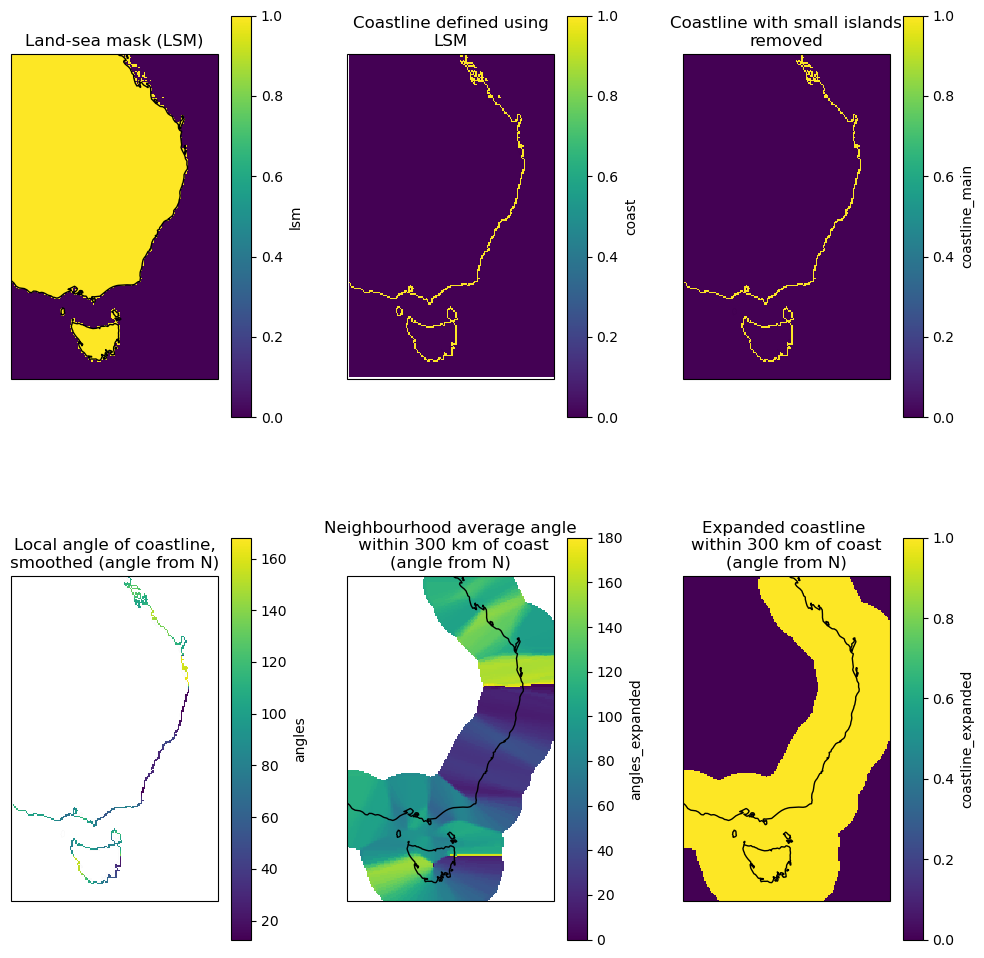

In [5]:
plt.figure(figsize=[12,12])
ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
lsm_ds.lsm.plot()
plt.title("Land-sea mask (LSM)")
ax.coastlines()

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
lsm_ds.coast.plot()
plt.title("Coastline defined using\nLSM")
ax.coastlines(lw=0.01)

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
lsm_ds.coastline_main.plot()
plt.title("Coastline with small islands\nremoved")
ax.coastlines(lw=0.01)

ax=plt.subplot(2,3,4,projection=ccrs.PlateCarree())
lsm_ds.angles.plot()
plt.title("Local angle of coastline,\nsmoothed (angle from N)")
ax.coastlines(lw=0.01)

ax=plt.subplot(2,3,5,projection=ccrs.PlateCarree())
lsm_ds.angles_expanded.plot(vmin=0,vmax=180)
plt.title("Neighbourhood average angle\n within 300 km of coast\n(angle from N)")
ax.coastlines()

ax=plt.subplot(2,3,6,projection=ccrs.PlateCarree())
lsm_ds.coastline_expanded.plot()
plt.title("Expanded coastline \nwithin 300 km of coast\n(angle from N)")
ax.coastlines()

plt.subplots_adjust(hspace=0.3,wspace=0.3)

In [ ]:
#take dLSM/dx to find out if coastline is eastward or westward-facing
#then, if angle is 0-90 and coastline is eastward-facing, positive vprime will be onshore.
#Or if angle is 90-180 and coastline is westward-facing, positive vprime will be onshore.
#Or if 

In [561]:
lat_slice = slice(-45,-5)
lon_slice = slice(110,155)
orog, lsm = load_barra_static("AUS-11",lon_slice,lat_slice)
#lsm_ds = get_coastline(lsm)
#lsm_ds = get_coastline_angle(lsm_ds, R=300, N=10)

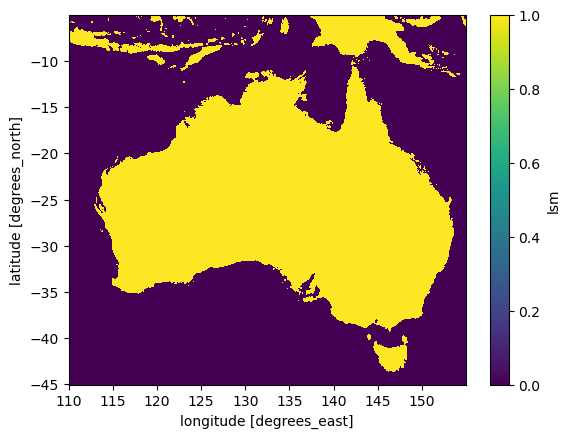

In [562]:
coastline = (np.abs(((lsm.diff("lat")) + (lsm.diff("lon")))) >= 1)
coastline = (np.abs(lsm.diff("lat")) + np.abs(lsm.diff("lon")))# >= 1
lsm_dlon = lsm.diff("lon") + lsm.diff("lat")
lsm_dlat = lsm.diff("lat")# + lsm.diff("lat")
lsm_ds = xr.Dataset({"lsm":lsm,"coast":coastline,"lsm_dlon":lsm_dlon,"lsm_dlat":lsm_dlat})

lsm_ds.lsm.plot()


In [682]:
from skimage.measure import label, centroid
from skimage.segmentation import find_boundaries
from skimage.morphology import erosion, dilation, opening, closing, white_tophat  # noqa

erosion_footprint=disk(2)
size_thresh=10

#Label the binary land sea mask, while applying an erosion method to remove
#parts of the coast connected by skinny land bridges (the algorithm for ordering 
#the coastline points has trouble with that)
label = label(erosion(lsm,footprint=erosion_footprint),connectivity=1)

#Remove labelled land masses smaller than some size threshold
unique_labels = np.unique(label)
for l in unique_labels:
    if l>0:
        if (label==l).sum() <= size_thresh:
            label[label==l] = 0
unique_labels = np.unique(label)                

#Get boundaries (coastlines)
coastline_masks = []
label_masks = []
for l in unique_labels:
    if l>0:
        coastline_masks.append(find_boundaries(label==l, connectivity=1, mode="inner"))
        label_masks.append(label==l)

coastline_masks = dict(zip(np.arange(len(unique_labels)),coastline_masks))
label_masks = dict(zip(np.arange(len(unique_labels)),label_masks))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [618]:
bounds = find_boundaries(label==3, connectivity=1, mode="outer")
bound_xind, bound_yind= np.where(bounds==1)
lon, lat = np.meshgrid(lsm_ds.lon, lsm_ds.lat)

centre_xind, centre_yind = centroid(label).round().astype(int)

def less(a_x, a_y, b_x, b_y, centre_xind, centre_yind):

    if (a_x - centre_xind >= 0) & (b_x - centre_xind < 0):
        #print(1)
        return True
    if (a_x - centre_xind < 0) & (b_x - centre_xind >= 0):
        #print(2)
        return False
    if (a_x - centre_xind == 0) & (b_x - centre_xind == 0):
        #print(3)
        if (a_y - centre_yind >= 0) | (b_y - centre_yind >= 0):
            return a_y > b_y
        else:
            return b_y > a_y
    

    #compute the cross product of vectors (centre -> a) x (centre -> b)
    det = (a_x - centre_xind) * (b_y - centre_yind) - (b_x - centre_xind) * (a_y - centre_yind)
    #print(det)
    if (det < 0):
        #print(4)
        return True
    if (det > 0):
        #print(5)
        return False

    #points a and b are on the same line from the centre
    #check which point is closer to the centre
    d1 = (a_x - centre_xind) * (a_x - centre_xind) + (a_y - centre_yind) * (a_y - centre_yind)
    d2 = (b_x - centre_xind) * (b_x - centre_xind) + (b_y - centre_yind) * (b_y - centre_yind)

    return d1 > d2;
    
    

point_inds = np.arange(len(bound_xind))

# for a in point_inds[0:10]:
    
#     b=a+1
    
#     a_x = bound_xind[a]
#     a_y = bound_yind[a]
#     b_x = bound_xind[b]
#     b_y = bound_yind[b]
    
#     is_less = less(a_x, a_y, b_x, b_y, centre_xind, centre_yind)
    


In [619]:
# a=10
# sorted_inds = []


# for i in range(10): 

#     #Get the x and i indices of the current point
#     a_x = bound_xind[a]
#     a_y = bound_yind[a]

#     #Define a list of all neighbouring points
#     neighbours = [[a_x-1,a_y+1], [a_x,a_y+1], [a_x+1,a_y+1],
#      [a_x-1,a_y], [a_x+1,a_y],
#      [a_x-1,a_y-1], [a_x,a_y-1], [a_x+1,a_y-1]]
    
#     neighbour_less = []
#     dist = []
#     in_sorted_inds = []
#     #Loop over all neighbouring points
#     for b in neighbours:
#         #If this neighbouring point is a boundary (coastline)
#         if bounds[b[0],b[1]]:
#             #Then are there points in a clockwise direction (using the less algorithm)
#             is_less = less(a_x, a_y, b[0], b[1], centre_xind, centre_yind)
#             #Keep track if the neighbouring point is in a clockwise direction
#             neighbour_less.append(is_less)
#             #Keep track of the distance of the neighbouring points from the centre of mass (for ties):
#             #If the point has already been walked, then record a distance of zero (so the point won't be used in the case of a tie)
#             if np.sum( (np.in1d(bound_yind[sorted_inds], b[1])) & (np.in1d(bound_xind[sorted_inds], b[0])) )>=1:
#                 dist.append(0)
#             else:
#                 dist.append(((b[0] - centre_xind) * (b[0] - centre_xind) + (b[1] - centre_yind) * (b[1] - centre_yind)))
#         else:
#             neighbour_less.append(False)
#             dist.append(0)

#     #To break ties, get the neighbour furthest from centre
#     if np.sum(neighbour_less) == 1:
#         next_point = np.array(neighbours)[np.in1d(neighbour_less,True)].squeeze()
#     elif np.sum(neighbour_less) == 0:
#         next_point = neighbours[np.argmax(dist)]
#     else:
#         next_point = np.array(neighbours)[np.in1d(neighbour_less,True)].squeeze()
#         dist = np.array(dist)[np.in1d(neighbour_less,True)].squeeze()
#         next_point = next_point[np.argmax(dist)]
#         #next_point = np.array(neighbours)[np.in1d(neighbour_less,True)].squeeze()

#     #print( np.sum(neighbour_less) )
#     a = point_inds[(bound_xind==next_point[0]) & (bound_yind==next_point[1]) & (~np.in1d(point_inds,sorted_inds))][0]
#     sorted_inds.append(a)

# plt.pcolormesh(bounds)
# #plt.plot(a_y,a_x,marker="o")
# #plt.plot(np.array(neighbours)[:,1], np.array(neighbours)[:,0],marker="o",ls="none",ms=2)
# #plt.plot(np.array(neighbours)[np.in1d(neighbour_less,True),1], np.array(neighbours)[np.in1d(neighbour_less,True),0],marker="o",ls="none",ms=2)
# plt.plot(bound_yind[sorted_inds], bound_xind[sorted_inds],marker="o")

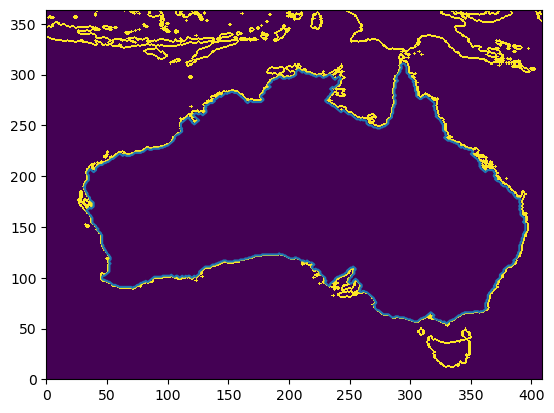

In [742]:
a=0
sorted_inds = []


for _ in range(1200): 

    #Get the x and i indices of the current point
    a_x = bound_xind[a]
    a_y = bound_yind[a]

    #Define a list of all neighbouring points
    neighbours = [[a_x-1,a_y+1], [a_x,a_y+1], [a_x+1,a_y+1],
     [a_x-1,a_y], [a_x+1,a_y],
     [a_x-1,a_y-1], [a_x,a_y-1], [a_x+1,a_y-1]]
    
    det_ls = []
    #Loop over all neighbouring points
    for b in neighbours:
        #If this neighbouring point is a boundary (coastline)
        if bounds[b[0],b[1]]:
            if np.sum( (np.in1d(bound_yind[sorted_inds], b[1])) & (np.in1d(bound_xind[sorted_inds], b[0])) )>=1:
                det_ls.append(np.nan)
            else:
                #Then are there points in a clockwise direction (using the less algorithm)
                det_ls.append((a_x - centre_xind) * (b[1] - centre_yind) - (b[0] - centre_xind) * (a_y - centre_yind))
        else:
            det_ls.append(np.nan)

    if np.isnan(det_ls).all():
        break_loop = True
    else:
        break_loop = False
        next_point = neighbours[np.nanargmin(det_ls)]

    if break_loop:
        break

    #print( np.sum(neighbour_less) )
    
    #next_pos = (bound_xind==next_point[0]) & (bound_yind==next_point[1]) & (~np.in1d(point_inds,sorted_inds))
    # if next_pos.sum() >= 1:
    #     a = point_inds[next_pos][0]
    #     sorted_inds.append(a)
    #     break_loop = False
    # else:
    #     break_loop = True

    # if break_loop:
    #     break

    a = point_inds[(bound_xind==next_point[0]) & (bound_yind==next_point[1]) & (~np.in1d(point_inds,sorted_inds))][0]
    sorted_inds.append(a)


plt.pcolormesh(find_boundaries(lsm))
#plt.plot(a_y,a_x,marker="o")
#plt.plot(np.array(neighbours)[:,1], np.array(neighbours)[:,0],marker="o",ls="none",ms=2)
#plt.plot(np.array(neighbours)[np.in1d(neighbour_less,True),1], np.array(neighbours)[np.in1d(neighbour_less,True),0],marker="o",ls="none",ms=2)
plt.plot(bound_yind[sorted_inds], bound_xind[sorted_inds])

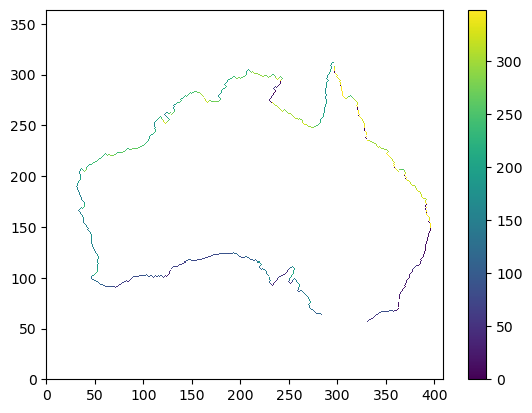

In [798]:
angles = np.zeros(lsm.shape) * np.nan
lon = lsm.lon.values
lat = lsm.lat.values

for ind in range(len(sorted_inds)-50):

    
    
    angles[bound_xind[sorted_inds[ind]], bound_yind[sorted_inds[ind]]] = np.arctan2(lat[bound_xind[sorted_inds[ind+5]]] - lat[bound_xind[sorted_inds[ind]]],
                                                          lon[bound_yind[sorted_inds[ind+5]]] - lon[bound_yind[sorted_inds[ind]]])


angles = np.rad2deg(angles)
angles = -(angles-90) % 360
plt.pcolormesh(angles);plt.colorbar()

In [799]:
np.unique(angles)

array([  0.        ,  11.30993247,  11.30993247,  11.30993247,
        11.30993247,  11.30993247,  11.30993247,  11.30993247,
        18.43494882,  21.80140949,  21.80140949,  21.80140949,
        21.80140949,  21.80140949,  21.80140949,  30.96375653,
        30.96375653,  30.96375653,  30.96375653,  30.96375653,
        30.96375653,  30.96375653,  30.96375653,  36.86989765,
        38.65980825,  38.65980825,  38.65980825,  38.65980825,
        45.        ,  45.        ,  45.        ,  51.34019175,
        51.34019175,  51.34019175,  51.34019175,  53.13010235,
        53.13010235,  59.03624347,  59.03624347,  59.03624347,
        59.03624347,  59.03624347,  59.03624347,  59.03624347,
        68.19859051,  68.19859051,  68.19859051,  68.19859051,
        68.19859051,  75.96375653,  78.69006753,  78.69006753,
        78.69006753,  78.69006753,  78.69006753,  90.        ,
       101.30993247, 101.30993247, 101.30993247, 101.30993247,
       101.30993247, 101.30993247, 104.03624347, 108.43

In [792]:
sorted_inds[5]

26

In [785]:
lat[bound_xind[3]]

-38.83

In [786]:
lon[bound_yind[3]]

146.45

In [771]:

#Get the x and i indices of the current point
a_x = bound_xind[a]
a_y = bound_yind[a]

#Define a list of all neighbouring points
neighbours = [[a_x-1,a_y+1], [a_x,a_y+1], [a_x+1,a_y+1],
 [a_x-1,a_y], [a_x+1,a_y],
 [a_x-1,a_y-1], [a_x,a_y-1], [a_x+1,a_y-1]]

det_ls = []
#Loop over all neighbouring points
for b in neighbours:
    #If this neighbouring point is a boundary (coastline)
    if bounds[b[0],b[1]]:
        #Then are there points in a clockwise direction (using the less algorithm)
        det_ls.append((a_x - centre_xind) * (b[1] - centre_yind) - (b[0] - centre_xind) * (a_y - centre_yind))
    else:
        det_ls.append(np.nan)

neighbours[np.nanargmin(det_ls)]

[56, 331]

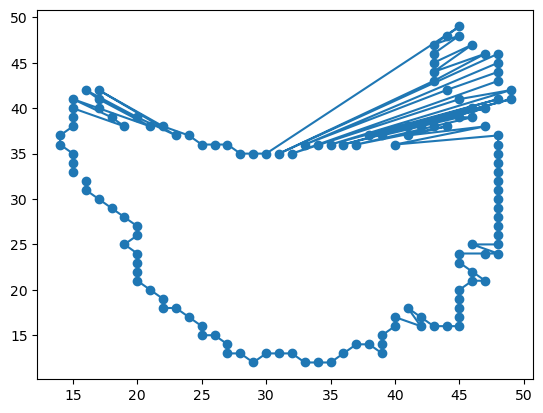

In [109]:
import math                      # atan2

def sort_counterclockwise(points, centre = None):
  if centre:
    centre_x, centre_y = centre
  else:
    centre_x, centre_y = sum([x for x,_ in points])/len(points), sum([y for _,y in points])/len(points)
  angles = [math.atan2(y - centre_y, x - centre_x) for x,y in points]
  counterclockwise_indices = sorted(range(len(points)), key=lambda i: angles[i])
  counterclockwise_points = [points[i] for i in counterclockwise_indices]
  return counterclockwise_points

points = [(bound_yind[i], bound_xind[i]) for i in range(len(bound_xind))]    

points = sort_counterclockwise(points, (centre_xind, centre_yind))

plt.plot([x for x,_ in points], [y for _,y in points],marker="o")

In [133]:
import numpy as np
import xarray as xr
import tqdm
from skimage.segmentation import flood
import scipy

r=50; R=300; N=10; small_coast_thresh=0.001

#Define the x and y grid, and remove the xarray metadata for the coastline dataset
x = lsm_ds.lon.values
y = lsm_ds.lat.values
xx,yy = np.meshgrid(x,y)
coastline = lsm_ds.coast.values

#Initialise an "angle" array and an lsm_dlon array
# angles = np.ones(coastline.shape) * np.nan
# lsm_dlon = np.ones(coastline.shape) * np.nan

# #Loop over all points in the spatial domain
# print("Defining coastline angles...")
# for xi in tqdm.tqdm(range(coastline.shape[1])):
#     for yi in range(coastline.shape[0]):

#         #If this point is a coastline...
#         if coastline[yi,xi] == 1:

xi=37
yi=14

#Get all connected points using scikit image
connected = flood(coastline,(yi,xi)) 

#Now, if the number of connected points is greater than some threshold 
#(here, 0.001 would represent 0.1% of points of the whole domain), do the following
#This is used to exclude small islands
if connected.sum() / (connected.shape[0] * connected.shape[1]) > small_coast_thresh:

   print(xi,yi)

#Mask the connected points that are further away than r km
dist_mask = (latlon_dist(y[yi], x[xi], yy, xx) <= r) * 1
connected_close = connected * dist_mask

#Fit a linear polynomial through the neighbouring connected points, to estimate the local orientation of the coast
y_ind, x_ind  = np.where(connected_close)
fit_xy = np.polyfit(x[x_ind],y[y_ind],deg=1)
yf = np.polyval(fit_xy, x)

#From this polynomial, calculate the angle from north
angle_fit = np.arctan2(yf[-1] - yf[0], x[-1] - x[0])
angle_fit = np.rad2deg(angle_fit)
angle_fit = -(angle_fit-90) % 360

#Keep track of all the angles
angles[yi,xi] = angle_fit    

plt.pcolormesh(xx,yy,coastline * dist_mask); plt.colorbar()

y_ind2, x_ind2 = np.where((coastline * dist_mask)==1)
plt.plot(x[x_ind2], y[y_ind2], marker="x",ls="none")
plt.plot(x[xi], y[yi], marker="x",ls="none")

for ii in range(len(x_ind2)):
    if ~( (y[y_ind2][ii]==y[yi]) & (x[x_ind2][ii]==x[xi]) ):
        print(np.rad2deg(np.arctan2(y[y_ind2][ii]-y[yi],x[x_ind2][ii]-x[xi])))



37 14


NameError: name 'angles' is not defined

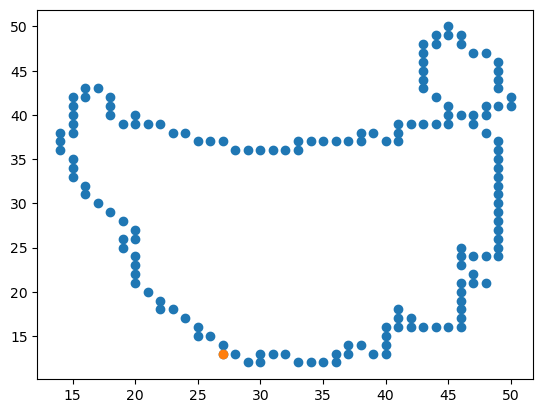

In [211]:
y_ind, x_ind  = np.where(connected==1)
plt.plot(x_ind,y_ind,marker="o",ls="none")

i=6
plt.plot(x_ind[i],y_ind[i],color="tab:orange",marker="o")

In [117]:
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
import shapely

point=shapely.points(np.array([bound_yind,bound_xind]).T)
poly=shapely.polygons(np.array([bound_yind,bound_xind]).T)

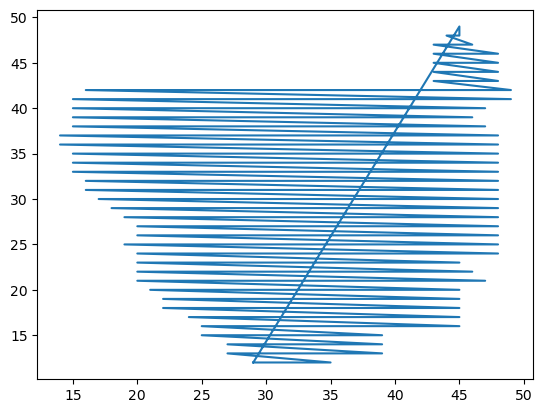

In [132]:
poly=shapely.geometry.polygon.orient(poly)
plt.plot(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])

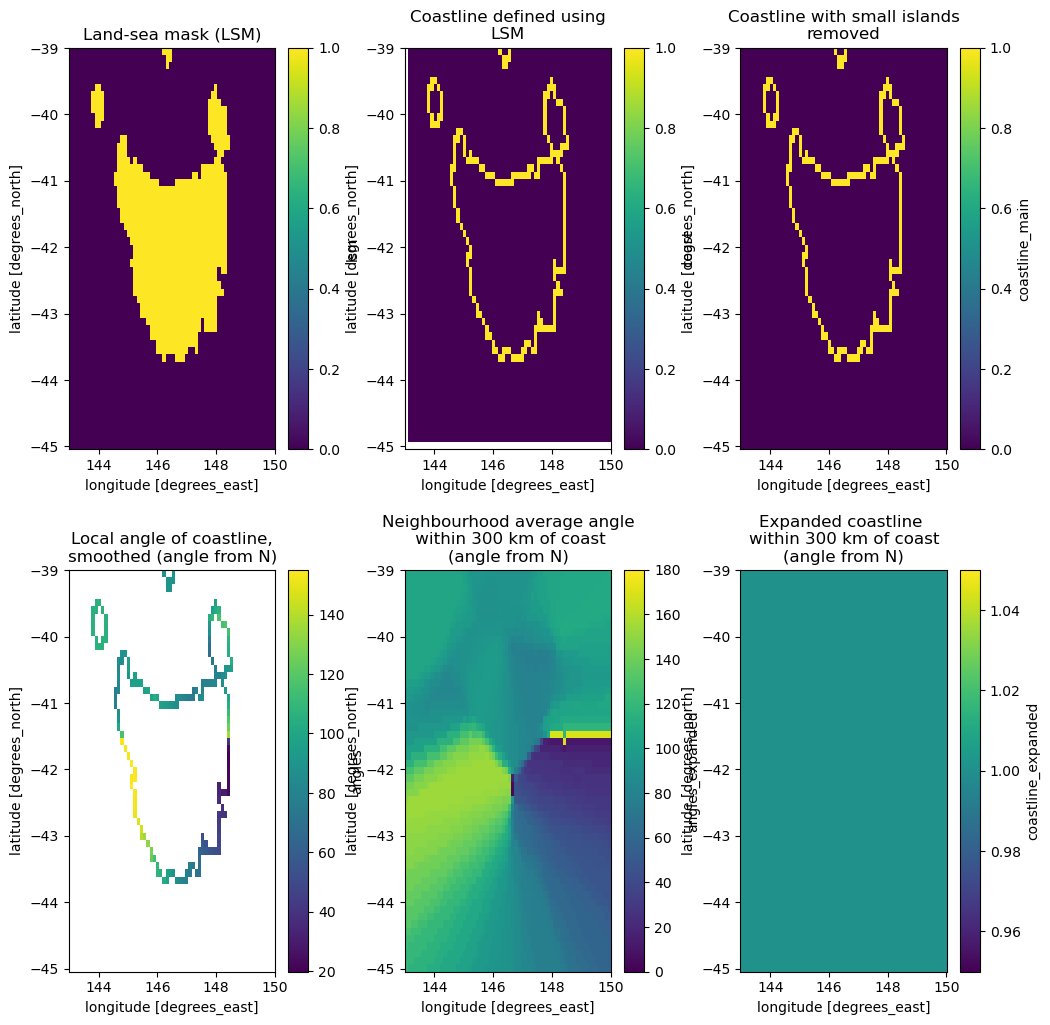

In [11]:
plt.figure(figsize=[12,12])
plt.subplot(2,3,1)
lsm_ds.lsm.plot()
plt.title("Land-sea mask (LSM)")

plt.subplot(2,3,2)
lsm_ds.coast.plot()
plt.title("Coastline defined using\nLSM")

plt.subplot(2,3,3)
lsm_ds.coastline_main.plot()
plt.title("Coastline with small islands\nremoved")

plt.subplot(2,3,4)
lsm_ds.angles.plot()
plt.title("Local angle of coastline,\nsmoothed (angle from N)")

plt.subplot(2,3,5)
lsm_ds.angles_expanded.plot(vmin=0,vmax=180)
plt.title("Neighbourhood average angle\n within 300 km of coast\n(angle from N)")

plt.subplot(2,3,6)
lsm_ds.coastline_expanded.plot()
plt.title("Expanded coastline \nwithin 300 km of coast\n(angle from N)")

plt.subplots_adjust(hspace=0.3,wspace=0.3)

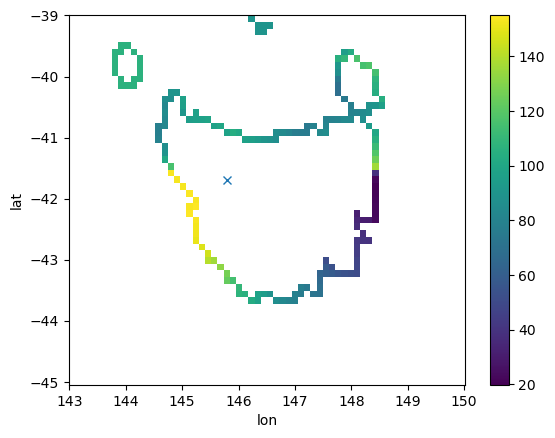

In [8]:
import scipy
xi=30
yi=25
x = lsm_ds.lon.values
y = lsm_ds.lat.values
xx,yy = np.meshgrid(x,y)
R=300

dist = latlon_dist(yy[xi,yi], xx[xi,yi], yy, xx)
# np.rad2deg(
#     scipy.stats.circmean(
#     np.deg2rad(xr.where((lsm_ds.coastline_main) & (dist<=R),lsm_ds.angles,np.nan)), 
#     high=np.pi, low=0, nan_policy="omit"))

(xr.where((lsm_ds.coastline_main) & (dist<=R),lsm_ds.angles,np.nan)).plot()
plt.plot(xx[xi,yi], yy[xi,yi],marker="x")

array([153.96868783, 154.14717804, 153.28816972, 154.68659024,
       152.98923393, 153.92256071,  96.99892772, 155.05898396,
        95.87621914, 153.82202815])

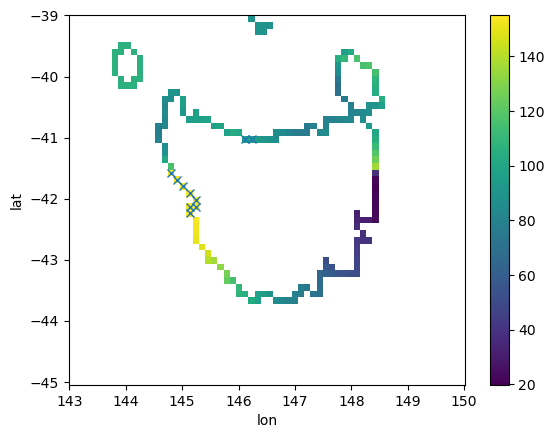

In [30]:
N=10
R=300
flattened_xx = xx.flatten()
flattened_yy = yy.flatten()
flattened_angles = lsm_ds.angles.values.flatten()
closest_n_xx = flattened_xx[np.argsort(xr.where((lsm_ds.coastline_main),dist,np.nan).values,axis=None)[0:N]]
closest_n_yy = flattened_yy[np.argsort(xr.where((lsm_ds.coastline_main),dist,np.nan).values,axis=None)[0:N]]

(xr.where((lsm_ds.coastline_main) & (dist<=R),lsm_ds.angles,np.nan)).plot()
plt.plot(closest_n_xx, closest_n_yy, marker="x", ls="none")

flattened_angles[np.argsort(xr.where((lsm_ds.coastline_main),dist,np.nan).values,axis=None)[0:N]]

In [26]:
R=None
N=None

assert (R is not None) | (N is not None), "R or N must be an integer"

AssertionError: R or N must be an integer

In [16]:
# def plot_sfc_wind(sfc_wind,ax,vmax=None,vmin=None,cmap=None,ws=True):
#     if ws:
#         sfc_wind.ws_sfc.plot(vmax=vmax,vmin=vmin,cmap=cmap)
#     sfc_wind[["uas","vas"]].coarsen({"lon":2,"lat":2},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="uas",v="vas")
#     ax.coastlines()
#     ax.gridlines(draw_labels=True)

# def plot_ds(ds,var_name,ax,vmin=None,vmax=None,cmap=None):
#     ds[var_name].plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap)

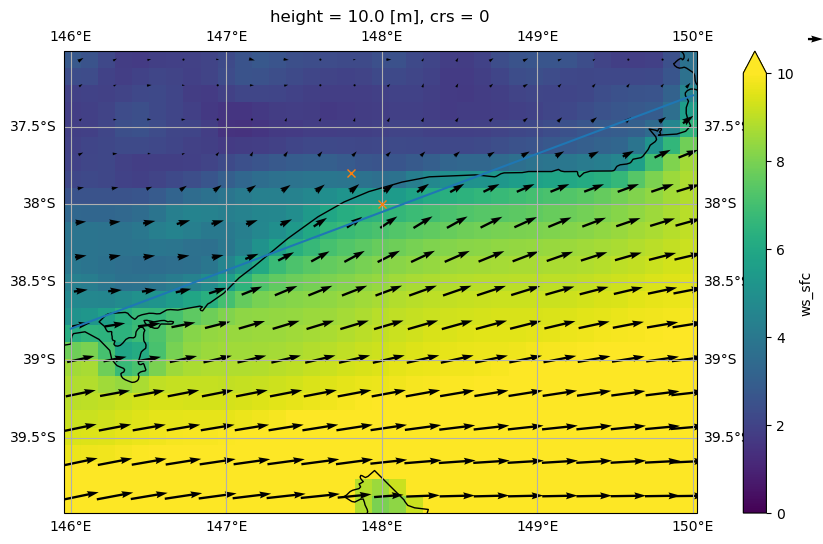

In [17]:
# lat_slice_gipps = slice(-40,-37)
# lon_slice_gipps = slice(146,150)

# plt.figure(figsize=[12,6])
# ax=plt.axes(projection=ccrs.PlateCarree())
# plot_sfc_wind(wind_ds.mean("time").sel(lat=lat_slice_gipps,lon=lon_slice_gipps), ax, vmin=0, vmax=10)
# plt.gca().plot(148,-38,marker="x",color="tab:orange")
# plt.gca().plot(147.8,-37.8,marker="x",color="tab:orange")
# plt.plot([146,150],[-38.8,-37.3])